In [1]:
# ============================================================================
# CELL 1: Import Required Libraries
## Enhanced Dental Practice Valuation Q&A Pipeline
# With Productivity and Procedures Data Integration

# ============================================================================
# CELL 1: Import Required Libraries
# ============================================================================

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import requests
from typing import Dict, List, Optional, Tuple, Any
import warnings
import re
from datetime import datetime
import os
warnings.filterwarnings('ignore')

# Set style for matplotlib
plt.style.use('seaborn-v0_8-darkgrid')

print("Libraries imported successfully!")

Libraries imported successfully!


In [9]:
# ============================================================================
# CELL 2: Configuration and API Setup
# ============================================================================

# OpenRouter API Configuration
OPENROUTER_API_KEY = "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"  # Replace with actual key (format: sk-or-v1-...)
OPENROUTER_URL = "https://openrouter.ai/api/v1/chat/completions"

# Model selection (free tier)
MODEL = "deepseek/deepseek-chat-v3.1:free"  # Free model
# Alternative free models if needed:
# MODEL = "mistralai/mistral-7b-instruct:free"
# MODEL = "huggingfaceh4/zephyr-7b-beta:free"

# Headers for API requests - Updated for better compatibility
def get_headers():
    """Get headers with proper API key format"""
    return {
        "Authorization": f"Bearer {OPENROUTER_API_KEY}",
        "HTTP-Referer": "http://localhost:3000",  # Optional but recommended
        "X-Title": "Dental Practice Q&A",  # Optional
        "Content-Type": "application/json"
    }

headers = get_headers()

# Test API connection with better error reporting
def test_api_connection():
    """Test if the API key is valid and connection works"""
    if OPENROUTER_API_KEY == "your-api-key-here":
        print("⚠️ WARNING: API key not set! Please replace 'your-api-key-here' with your actual OpenRouter API key")
        print("Get your free API key from: https://openrouter.ai/keys")
        print("Format should be: sk-or-v1-xxxxxxxxxxxxx")
        return False
    
    if not OPENROUTER_API_KEY.startswith("sk-or-"):
        print("⚠️ WARNING: API key format might be incorrect.")
        print("OpenRouter keys typically start with 'sk-or-v1-'")
        print(f"Your key starts with: {OPENROUTER_API_KEY[:8]}...")
    
    try:
        print(f"Testing API connection with key: {OPENROUTER_API_KEY[:8]}...{OPENROUTER_API_KEY[-4:]}")
        
        test_response = requests.post(
            OPENROUTER_URL,
            headers=headers,
            json={
                "model": MODEL,
                "messages": [{"role": "user", "content": "Say 'connected'"}],
                "max_tokens": 10,
                "stream": False
            },
            timeout=10
        )
        
        print(f"Response status: {test_response.status_code}")
        
        if test_response.status_code == 200:
            print(f"✓ API configured successfully with model: {MODEL}")
            response_json = test_response.json()
            if 'choices' in response_json:
                print(f"✓ Test message received: {response_json['choices'][0]['message']['content']}")
            return True
        elif test_response.status_code == 401:
            print(f"✗ Authentication failed (401)")
            print(f"Response: {test_response.text}")
            print("\nTroubleshooting steps:")
            print("1. Check your API key is correct at: https://openrouter.ai/keys")
            print("2. Make sure the key is active and has credits")
            print("3. Try regenerating the key if it's not working")
            return False
        elif test_response.status_code == 402:
            print(f"✗ Insufficient credits (402)")
            print("Add credits at: https://openrouter.ai/credits")
            return False
        else:
            print(f"✗ API error: Status {test_response.status_code}")
            print(f"Response: {test_response.text}")
            return False
            
    except requests.exceptions.Timeout:
        print(f"✗ Connection timeout - API might be slow")
        return False
    except Exception as e:
        print(f"✗ Connection error: {e}")
        print("\nMake sure you have an internet connection and OpenRouter is accessible")
        return False

# Run the test
print("="*60)
print("OpenRouter API Configuration Test")
print("="*60)
api_connected = test_api_connection()

if not api_connected:
    print("\n" + "="*60)
    print("FALLBACK MODE ACTIVE")
    print("="*60)
    print("The system will work without the LLM and provide data-based analysis.")
    print("To enable LLM features:")
    print("1. Get a free API key from: https://openrouter.ai/keys")
    print("2. Replace 'your-api-key-here' with your actual key above")
    print("3. Run this cell again")
else:
    print("\n" + "="*60)
    print("SYSTEM READY")
    print("="*60)
    print("LLM features are enabled and working!")

OpenRouter API Configuration Test
Testing API connection with key: sk-or-v1...a26f
Response status: 200
✓ API configured successfully with model: deepseek/deepseek-chat-v3.1:free
✓ Test message received: connected

SYSTEM READY
LLM features are enabled and working!


In [23]:
# ============================================================================
# CELL 3: Enhanced Data Loading and Validation Functions
# ============================================================================

class DentalPracticeData:
    """Enhanced class to handle dental practice data from multiple sources"""
    
    def __init__(self, 
                 productivity_csv: Optional[str] = None,
                 taxes_sde_csv: Optional[str] = None,
                 pnl_sde_csv: Optional[str] = None,
                 procedures_csv: Optional[str] = None):
        """
        Initialize with CSV files for productivity and SDE calculations
        
        Args:
            productivity_csv: Path to productivity CSV file
            taxes_sde_csv: Path to tax-based SDE calculation CSV (2022-2024)
            pnl_sde_csv: Path to P&L-based SDE calculation CSV (2022-2025)
            procedures_csv: Path to procedures CSV file (optional, on hold)
        """
        # Initialize data storage
        self.data = {}
        
        # Load productivity data if provided
        self.productivity_data = None
        if productivity_csv:
            self.productivity_data = self._load_productivity_data(productivity_csv)
            
        # Load SDE data from taxes if provided
        self.taxes_sde_data = None
        if taxes_sde_csv:
            self.taxes_sde_data = self._load_taxes_sde_data(taxes_sde_csv)
            
        # Load SDE data from P&L if provided
        self.pnl_sde_data = None
        if pnl_sde_csv:
            self.pnl_sde_data = self._load_pnl_sde_data(pnl_sde_csv)
            
        # Load procedures data if provided (on hold for now)
        self.procedures_data = None
        if procedures_csv:
            self.procedures_data = self._load_procedures_data(procedures_csv)
            
        # Calculate derived metrics and prepare valuation data
        self._calculate_sde_metrics()
        self._calculate_derived_metrics()
        self._prepare_valuation_data()
        
    def _load_productivity_data(self, csv_path: str) -> pd.DataFrame:
        """Load and process productivity CSV data"""
        try:
            df = pd.read_csv(csv_path)
            
            # Handle column name variations
            if 'provider_name' in df.columns and 'provider' not in df.columns:
                df = df.rename(columns={'provider_name': 'provider'})
            
            print(f"Productivity CSV columns: {list(df.columns)}")
            
            # Clean numeric columns
            numeric_cols = ['patients_seen', 'avg_visit_fee', 'production', 
                           'collection', 'adjustments']
            for col in numeric_cols:
                if col in df.columns:
                    df[col] = pd.to_numeric(df[col].astype(str).str.replace('$', '').str.replace(',', ''), errors='coerce')
            
            print(f"Loaded productivity data: {len(df)} records")
            return df
        except Exception as e:
            print(f"Error loading productivity data: {e}")
            return None
    
    def _load_taxes_sde_data(self, csv_path: str) -> pd.DataFrame:
        """Load and process tax-based SDE calculation data"""
        try:
            df = pd.read_csv(csv_path)
            print(f"Taxes SDE CSV columns: {list(df.columns)}")
            
            # Clean numeric columns - handle various formats
            for col in df.columns:
                if col not in ['Year', 'year']:
                    # Try to convert to numeric, handling currency symbols
                    df[col] = pd.to_numeric(
                        df[col].astype(str).str.replace('$', '').str.replace(',', '').str.replace('(', '-').str.replace(')', ''),
                        errors='coerce'
                    )
            
            print(f"Loaded taxes SDE data: {len(df)} records for years {df.get('Year', df.get('year', [])).unique()}")
            return df
        except Exception as e:
            print(f"Error loading taxes SDE data: {e}")
            return None
    
    def _load_pnl_sde_data(self, csv_path: str) -> pd.DataFrame:
        """Load and process P&L-based SDE calculation data"""
        try:
            df = pd.read_csv(csv_path)
            print(f"P&L SDE CSV columns: {list(df.columns)}")
            
            # Clean numeric columns
            numeric_columns = ['Automobile', 'Contributions', 'Legal Fees', 'Miscellaneous',
                              'Travel & Entertainment', 'Owner Excess Compensation', 
                              'Debit', 'Credit', 'Net', 'Total Discretionary Earnings']
            
            for col in numeric_columns:
                if col in df.columns:
                    df[col] = pd.to_numeric(
                        df[col].astype(str).str.replace('$', '').str.replace(',', '').str.replace('(', '-').str.replace(')', ''),
                        errors='coerce'
                    ).fillna(0)
            
            print(f"Loaded P&L SDE data: {len(df)} records for years {df.get('Year', df.get('year', [])).unique()}")
            return df
        except Exception as e:
            print(f"Error loading P&L SDE data: {e}")
            return None
    
    def _load_procedures_data(self, csv_path: str) -> pd.DataFrame:
        """Load and process procedures CSV data (keeping existing logic)"""
        try:
            df = pd.read_csv(csv_path)
            print(f"Procedures CSV columns: {list(df.columns)}")
            
            # Clean service names if present
            if 'service' in df.columns:
                df['service_clean'] = df['service'].apply(self._clean_service_name)
                df['service_category'] = df['service_clean'].apply(self._categorize_service)
            
            # Clean numeric columns
            numeric_cols = ['number', 'amount']
            for col in numeric_cols:
                if col in df.columns:
                    df[col] = pd.to_numeric(df[col].astype(str).str.replace('$', '').str.replace(',', ''), errors='coerce')
            
            print(f"Loaded procedures data: {len(df)} records")
            return df
        except Exception as e:
            print(f"Error loading procedures data: {e}")
            return None
    
    def _clean_service_name(self, service: str) -> str:
        """Clean service names using regex patterns (keeping existing logic)"""
        if pd.isna(service):
            return "Unknown"
        
        service = str(service).strip()
        
        # Common patterns to clean
        patterns = [
            (r'^D\d{4}\s*-?\s*', ''),  # Remove procedure codes at start
            (r'\s+', ' '),  # Multiple spaces to single
            (r'[^\w\s-]', ''),  # Remove special characters except dash
            (r'^\s*-\s*', ''),  # Remove leading dashes
        ]
        
        for pattern, replacement in patterns:
            service = re.sub(pattern, replacement, service)
        
        return service if service else "Unknown"
    
    def _categorize_service(self, service: str) -> str:
        """Categorize services into major groups (keeping existing logic)"""
        service_lower = service.lower()
        
        categories = {
            'Diagnostic': ['exam', 'x-ray', 'bitewing', 'panoramic', 'consult'],
            'Preventive': ['prophy', 'clean', 'fluoride', 'sealant'],
            'Restorative': ['filling', 'crown', 'bridge', 'composite', 'amalgam'],
            'Endodontic': ['root canal', 'endo', 'pulp'],
            'Periodontal': ['perio', 'scaling', 'root planing', 'gum'],
            'Oral Surgery': ['extraction', 'surgery', 'implant'],
            'Prosthodontic': ['denture', 'partial', 'prosth'],
            'Orthodontic': ['ortho', 'braces', 'aligner'],
        }
        
        for category, keywords in categories.items():
            if any(keyword in service_lower for keyword in keywords):
                return category
        
        return 'Other'
    
    def _calculate_sde_metrics(self):
        """Calculate SDE metrics from available data"""
        # Use P&L data as primary source (more comprehensive)
        if self.pnl_sde_data is not None:
            # Get year column name
            year_col = 'Year' if 'Year' in self.pnl_sde_data.columns else 'year'
            
            latest_year = self.pnl_sde_data[year_col].max()
            latest_data = self.pnl_sde_data[
                self.pnl_sde_data[year_col] == latest_year
            ].iloc[0] if not self.pnl_sde_data.empty else None
            
            if latest_data is not None:
                # Extract SDE components
                self.data['SDE_Components'] = {
                    'Owner_Excess_Compensation': float(latest_data.get('Owner Excess Compensation', 0)),
                    'Automobile': float(latest_data.get('Automobile', 0)),
                    'Contributions': float(latest_data.get('Contributions', 0)),
                    'Legal_Fees': float(latest_data.get('Legal Fees', 0)),
                    'Miscellaneous': float(latest_data.get('Miscellaneous', 0)),
                    'Travel_Entertainment': float(latest_data.get('Travel & Entertainment', 0)),
                }
                
                # Calculate total SDE
                self.data['Total_SDE'] = float(latest_data.get('Total Discretionary Earnings', 
                                                               sum(self.data['SDE_Components'].values())))
                
                # Store historical SDE for trending
                self.data['SDE_Historical'] = {}
                for _, row in self.pnl_sde_data.iterrows():
                    year = int(row[year_col]) if row[year_col] > 0 else None
                    if year:
                        self.data['SDE_Historical'][year] = float(row.get('Total Discretionary Earnings', 0))
        
        # Supplement with tax data if available
        elif self.taxes_sde_data is not None:
            latest_year = self.taxes_sde_data.get('Year', self.taxes_sde_data.get('year', pd.Series())).max()
            latest_data = self.taxes_sde_data[
                self.taxes_sde_data.get('Year', self.taxes_sde_data.get('year')) == latest_year
            ].iloc[0] if not self.taxes_sde_data.empty else None
            
            if latest_data is not None:
                # Map tax categories to SDE components
                self.data['SDE_Components'] = {
                    'Owner_Excess_Compensation': float(latest_data.get('Compensation (Excess over market)', 0)),
                    'Automobile': float(latest_data.get('Automobile (25% personal use)', 0)),
                    'Depreciation': float(latest_data.get('Depreciation Officer', 0) + 
                                        latest_data.get('Section179', 0)),
                    'Meals_Charitable': float(latest_data.get('Meals Charitable', 0)),
                }
                
                self.data['Total_SDE'] = sum(self.data['SDE_Components'].values())
    
    def _calculate_derived_metrics(self):
        """Calculate additional metrics from the data"""
        # Calculate Adjusted Net Income (which is effectively the revenue metric we care about)
        if 'Net_Income_Total' in self.data and 'Total_Addbacks' in self.data:
            # Adjusted Net Income = Net Income + Addbacks
            self.data['Adjusted_Net_Income'] = self.data['Net_Income_Total'] + self.data['Total_Addbacks']
            
            # For valuation purposes, we might want to use the average of recent years
            if 'SDE_Historical' in self.data and self.data['SDE_Historical']:
                recent_years = sorted(self.data['SDE_Historical'].keys())[-3:]  # Last 3 years
                if recent_years:
                    recent_sde_values = [self.data['SDE_Historical'][year] for year in recent_years]
                    self.data['Average_SDE_Recent'] = sum(recent_sde_values) / len(recent_sde_values)
        
        # If we have P&L data, get revenue/collections info
        if self.pnl_sde_data is not None and not self.pnl_sde_data.empty:
            # Get Debit/Credit for gross revenue understanding
            if 'Debit' in self.pnl_sde_data.columns:
                self.data['Total_Debit'] = self.pnl_sde_data['Debit'].sum()
            if 'Credit' in self.pnl_sde_data.columns:
                self.data['Total_Credit'] = self.pnl_sde_data['Credit'].sum()
            
            # For trailing 12 months, use the most recent year's data
            year_col = 'Year' if 'Year' in self.pnl_sde_data.columns else 'year'
            latest_year = self.pnl_sde_data[year_col].max()
            latest_year_data = self.pnl_sde_data[self.pnl_sde_data[year_col] == latest_year]
            
            if not latest_year_data.empty:
                latest_row = latest_year_data.iloc[0]
                # Use Net Income for the latest year as base
                self.data['Net_Income_Trailing12'] = float(latest_row.get('Net', 0))
                
                # Calculate SDE for trailing 12 months
                latest_sde_components = float(latest_row.get('Owner Excess Compensation', 0)) + \
                                       float(latest_row.get('Automobile', 0)) + \
                                       float(latest_row.get('Contributions', 0)) + \
                                       float(latest_row.get('Legal Fees', 0)) + \
                                       float(latest_row.get('Miscellaneous', 0)) + \
                                       float(latest_row.get('Travel & Entertainment', 0))
                
                # Add tax-based items for the latest year if available
                if self.taxes_sde_data is not None:
                    tax_year_col = 'Year' if 'Year' in self.taxes_sde_data.columns else 'year'
                    latest_tax_data = self.taxes_sde_data[self.taxes_sde_data[tax_year_col] == latest_year]
                    if not latest_tax_data.empty:
                        tax_row = latest_tax_data.iloc[0]
                        latest_sde_components += float(tax_row.get('Depreciation Officer', 0)) + \
                                                float(tax_row.get('Section179', 0))
                
                self.data['SDE_Trailing12'] = self.data['Net_Income_Trailing12'] + latest_sde_components
                
                # EBITDA approximation (SDE minus owner compensation)
                owner_comp = float(latest_row.get('Owner Excess Compensation', 0))
                self.data['EBITDA_Trailing12'] = self.data['SDE_Trailing12'] - (owner_comp * 0.5)  # Rough adjustment
        
        # Use productivity data for actual collections/production if available
        if self.productivity_data is not None and 'production' in self.productivity_data.columns:
            latest_year = self.productivity_data['year'].max() if 'year' in self.productivity_data.columns else None
            if latest_year:
                latest_year_data = self.productivity_data[self.productivity_data['year'] == latest_year]
                self.data['Production_Trailing12'] = latest_year_data['production'].sum()
                
                if 'collection' in latest_year_data.columns:
                    self.data['Collections_Trailing12'] = latest_year_data['collection'].sum()
                    self.data['Collection_Rate'] = (self.data['Collections_Trailing12'] / 
                                                   self.data['Production_Trailing12'] * 100) if self.data['Production_Trailing12'] > 0 else 0
        
        # For display purposes, use SDE_Trailing12 as the primary "Revenue" metric for valuation
        # This is because dental practice valuations are typically based on SDE
        if 'SDE_Trailing12' in self.data:
            self.data['Revenue_Trailing12'] = self.data.get('Production_Trailing12', self.data['SDE_Trailing12'])
        
        # Calculate margins if we have the data
        if 'SDE_Trailing12' in self.data and 'Production_Trailing12' in self.data:
            self.data['SDE_Margin'] = (self.data['SDE_Trailing12'] / 
                                      self.data['Production_Trailing12'] * 100) if self.data['Production_Trailing12'] > 0 else 0
        
        if 'EBITDA_Trailing12' in self.data and 'Production_Trailing12' in self.data:
            self.data['EBITDA_Margin'] = (self.data['EBITDA_Trailing12'] / 
                                         self.data['Production_Trailing12'] * 100) if self.data['Production_Trailing12'] > 0 else 0
    
    def _prepare_valuation_data(self):
        """Prepare data specifically for valuation report generation"""
        # Set practice information
        self.data['Practice_Overview'] = {
            'Name': 'Demo Dental Practice',  # This should be configurable
            'Location': 'Location TBD',
            'Valuation_Date': datetime.now().strftime('%Y-%m-%d'),
            'Operatories': 6,  # Default, should be configurable
        }
        
        # Calculate valuation multiples
        if 'Total_SDE' in self.data:
            # Industry standard multiples
            self.data['Valuation_Multiples'] = {
                'SDE_Multiple_Low': 3.5,
                'SDE_Multiple_High': 5.5,
                'SDE_Multiple_Mid': 4.5,
                'EBITDA_Multiple': 4.5,
                'Revenue_Multiple': 0.8
            }
            
            # Calculate implied valuations
            self.data['Implied_Valuations'] = {
                'SDE_Low': self.data['Total_SDE'] * self.data['Valuation_Multiples']['SDE_Multiple_Low'],
                'SDE_High': self.data['Total_SDE'] * self.data['Valuation_Multiples']['SDE_Multiple_High'],
                'SDE_Mid': self.data['Total_SDE'] * self.data['Valuation_Multiples']['SDE_Multiple_Mid'],
            }
            
            if 'EBITDA_Trailing12' in self.data:
                self.data['Implied_Valuations']['EBITDA'] = (
                    self.data['EBITDA_Trailing12'] * self.data['Valuation_Multiples']['EBITDA_Multiple']
                )
            
            if 'Revenue_Trailing12' in self.data:
                self.data['Implied_Valuations']['Revenue'] = (
                    self.data['Revenue_Trailing12'] * self.data['Valuation_Multiples']['Revenue_Multiple']
                )
    
    def get_comprehensive_context(self) -> str:
        """Get all available data as a formatted string for LLM context"""
        context = f"""
        === PRACTICE INFORMATION ===
        Name: {self.data.get('Practice_Overview', {}).get('Name', 'Unknown')}
        Location: {self.data.get('Practice_Overview', {}).get('Location', 'Unknown')}
        Valuation Date: {self.data.get('Practice_Overview', {}).get('Valuation_Date', 'Unknown')}
        
        === FINANCIAL METRICS ===
        Revenue (Trailing 12): ${self.data.get('Revenue_Trailing12', 0):,.0f}
        Collections (Trailing 12): ${self.data.get('Collections_Trailing12', 0):,.0f}
        Collection Rate: {self.data.get('Collection_Rate', 0):.1f}%
        EBITDA (Trailing 12): ${self.data.get('EBITDA_Trailing12', 0):,.0f}
        Total SDE: ${self.data.get('Total_SDE', 0):,.0f}
        EBITDA Margin: {self.data.get('EBITDA_Margin', 0):.1f}%
        SDE Margin: {self.data.get('SDE_Margin', 0):.1f}%
        
        === SDE COMPONENTS ==="""
        
        if 'SDE_Components' in self.data:
            for component, value in self.data['SDE_Components'].items():
                context += f"\n        {component.replace('_', ' ')}: ${value:,.0f}"
        
        context += f"""
        
        === VALUATION ===
        SDE Multiple Range: {self.data.get('Valuation_Multiples', {}).get('SDE_Multiple_Low', 0)}-{self.data.get('Valuation_Multiples', {}).get('SDE_Multiple_High', 0)}x
        Implied Valuation (Low): ${self.data.get('Implied_Valuations', {}).get('SDE_Low', 0):,.0f}
        Implied Valuation (High): ${self.data.get('Implied_Valuations', {}).get('SDE_High', 0):,.0f}
        """
        
        # Add productivity context if available
        if self.productivity_data is not None and not self.productivity_data.empty:
            context += f"""
        
        === PRODUCTIVITY METRICS ===
        Total Providers: {self.productivity_data['provider'].nunique() if 'provider' in self.productivity_data.columns else 0}
        Total Patients Seen: {self.productivity_data['patients_seen'].sum() if 'patients_seen' in self.productivity_data.columns else 0:,.0f}
        Average Visit Fee: ${self.productivity_data['avg_visit_fee'].mean() if 'avg_visit_fee' in self.productivity_data.columns else 0:.2f}
        """
        
        # Add historical SDE trend if available
        if 'SDE_Historical' in self.data and self.data['SDE_Historical']:
            context += "\n\n        === SDE TREND ==="
            for year, sde in sorted(self.data['SDE_Historical'].items()):
                context += f"\n        {year}: ${sde:,.0f}"
        
        return context

In [24]:
# ============================================================================
# CELL 4: Enhanced LLM Interaction Functions with Valuation Report Generation
# ============================================================================

def categorize_question(question: str) -> str:
    """Enhanced question categorization with valuation categories"""
    question_lower = question.lower()
    
    # Extended category mappings
    category_keywords = {
        'valuation': ['valuation', 'value', 'worth', 'sde', 'ebitda', 'multiple', 
                     'price', 'asking', 'offer', 'appraisal', 'assessment'],
        'sde': ['sde', 'seller discretionary', 'add-back', 'adjustment', 
                'discretionary earnings', 'owner benefit'],
        'financial': ['revenue', 'profit', 'ebitda', 'margin', 'collection', 
                     'financial', 'p&l', 'income', 'expense'],
        'productivity': ['productivity', 'production', 'collection', 'efficiency', 
                        'patients seen', 'visit fee', 'utilization'],
        'procedures': ['procedure', 'service', 'treatment', 'bitewing', 'crown',
                      'filling', 'exam', 'frequency', 'procedure mix'],
        'report': ['report', 'summary', 'comprehensive', 'full analysis', 
                  'detailed', 'complete'],
        'staffing': ['hygienist', 'staff', 'overtime', 'employee', 'turnover',
                    'ratio', 'utilization', 'satisfaction'],
        'location': ['location', 'address', 'demographics', 'population', 
                    'competition', 'accessibility', 'area'],
        'tax': ['tax', 'depreciation', 'amortization', 'write'],
        'trend': ['trend', 'historical', 'growth', 'decline', 'change', 'year over year']
    }
    
    for category, keywords in category_keywords.items():
        if any(keyword in question_lower for keyword in keywords):
            return category
    
    return 'general'

def detect_provider_in_question(question: str, practice_data: DentalPracticeData) -> Optional[str]:
    """Detect if a specific provider is mentioned in the question"""
    if practice_data.productivity_data is None:
        return None
    
    # Get list of all providers from available data
    providers = set()
    if practice_data.productivity_data is not None and 'provider' in practice_data.productivity_data.columns:
        providers.update(practice_data.productivity_data['provider'].dropna().unique())
    
    question_lower = question.lower()
    best_match = None
    best_score = 0
    
    # Check each provider for matches
    for provider in providers:
        provider_lower = provider.lower()
        score = 0
        
        # Check for full name match
        if provider_lower in question_lower:
            return provider
        
        # Check for partial matches
        provider_parts = provider.split()
        for part in provider_parts:
            if len(part) > 2:
                import re
                pattern = r'\b' + re.escape(part.lower()) + r'\b'
                if re.search(pattern, question_lower):
                    score += 1
        
        if score > best_score:
            best_score = score
            best_match = provider
    
    # Return best match if we found at least 2 matching parts
    if best_score >= 2:
        return best_match
    
    return None

def generate_valuation_report_prompt(practice_data: DentalPracticeData) -> str:
    """Generate a prompt for creating a comprehensive valuation report"""
    
    context = practice_data.get_comprehensive_context()
    
    prompt = f"""You are an expert dental practice valuation analyst. Generate a comprehensive valuation report based on the following practice data.

{context}

Create a professional valuation report that includes:

## Executive Summary
- Brief overview of the practice
- Key financial indicators (Revenue, EBITDA, SDE)
- Valuation range based on SDE multiples
- Investment highlights

## Practice Overview
- Practice name and location
- Key operational metrics
- Service offerings (if productivity data available)

## Financial Analysis
### Trailing Twelve-Month Performance
- Revenue and collections
- EBITDA and margins

### Seller's Discretionary Earnings (SDE) Calculation
- Detailed breakdown of SDE components
- Justification for each add-back
- Total SDE calculation

## Valuation Methodology
- Explanation of SDE multiple approach
- Applied multiples and rationale (use {practice_data.data.get('Valuation_Multiples', {}).get('SDE_Multiple_Low', 3.5)}-{practice_data.data.get('Valuation_Multiples', {}).get('SDE_Multiple_High', 5.5)}x range)
- Calculation of valuation range
- Cross-validation with EBITDA and Revenue multiples if available

## Key Value Drivers
- Strong financial performance metrics
- Collection rate efficiency
- Growth trends
- Operational strengths

## Risk Factors
- Industry-specific risks
- Practice-specific considerations
- Market conditions

## Conclusion
- Summary of valuation range
- Investment thesis
- Next steps for potential buyers

Format the report in clean markdown with proper headers, tables where appropriate, and professional language suitable for presentation to potential buyers or lenders."""
    
    return prompt

def generate_llm_prompt(question: str, practice_data: DentalPracticeData, category: str, provider_name: Optional[str] = None) -> str:
    """Generate a prompt based on question category and available data"""
    
    # Check if this is a valuation report request
    if category == 'report' or 'valuation report' in question.lower():
        return generate_valuation_report_prompt(practice_data)
    
    # For SDE or valuation specific questions
    if category in ['valuation', 'sde', 'financial']:
        prompt = f"""You are an expert dental practice valuation analyst. Answer the following question using the practice's financial and SDE data.

=== PRACTICE FINANCIAL DATA ===
{practice_data.get_comprehensive_context()}

Question: {question}

Provide a detailed answer that:
1. Directly addresses the question with specific numbers from the data
2. Explains the methodology or calculation if applicable
3. Provides context about what the numbers mean for practice valuation
4. Suggests relevant follow-up considerations

Use professional language suitable for practice owners and potential buyers."""
        return prompt
    
    # For productivity questions (existing functionality)
    prompt = "You are an expert dental practice analyst providing insights to practice owners and potential buyers.\n\n"
    
    # Add comprehensive context
    prompt += "=== COMPLETE PRACTICE DATA ===\n\n"
    prompt += practice_data.get_comprehensive_context()
    prompt += "\n\n"
    
    # Add productivity data if available and relevant
    if practice_data.productivity_data is not None and not practice_data.productivity_data.empty:
        if provider_name:
            prompt += f"=== SPECIFIC DATA FOR {provider_name.upper()} ===\n"
            provider_data = practice_data.productivity_data[
                practice_data.productivity_data['provider'] == provider_name
            ]
            if not provider_data.empty:
                prompt += "DETAILED RECORDS:\n"
                prompt += provider_data.to_string(index=False)
                prompt += "\n\n"
        else:
            prompt += "=== PRODUCTIVITY DATA ===\n"
            summary = practice_data.productivity_data.groupby(['provider', 'year']).agg({
                'production': 'sum',
                'collection': 'sum',
                'patients_seen': 'sum',
                'avg_visit_fee': 'mean'
            }).round(2)
            prompt += summary.to_string()
            prompt += "\n\n"
    
    # Add the question
    prompt += f"=== QUESTION ===\n{question}\n\n"
    
    # Instructions based on category
    if category == 'productivity':
        prompt += """=== INSTRUCTIONS ===
Focus on the specific metric asked about. Structure your response as:
1. **Direct Answer**: The specific metric with year-over-year changes
2. **Comparative Context**: How this compares to others or benchmarks
3. **Key Insights**: What the trend means for the practice
4. **Suggested Follow-ups**: Related questions to explore"""
    else:
        prompt += """=== INSTRUCTIONS ===
Provide a comprehensive answer that:
1. Uses specific data from the information provided
2. Includes relevant calculations or comparisons
3. Offers actionable insights
4. Maintains professional tone suitable for practice valuation context"""
    
    return prompt

def get_llm_response(prompt: str, max_retries: int = 3) -> str:
    """Get response from the LLM API with retry logic"""
    # Check if API key is set
    if OPENROUTER_API_KEY == "your-api-key-here":
        return "⚠️ API key not configured. Please set your OpenRouter API key in Cell 2."
    
    import time
    
    # Get fresh headers for each request
    headers = get_headers()
    
    for attempt in range(max_retries):
        try:
            print(f"Calling LLM API (attempt {attempt + 1}/{max_retries})...")
            
            response = requests.post(
                OPENROUTER_URL,
                headers=headers,
                json={
                    "model": MODEL,
                    "messages": [
                        {"role": "system", "content": "You are an expert dental practice valuation analyst with deep knowledge of practice financials, SDE calculations, and industry valuation multiples."},
                        {"role": "user", "content": prompt}
                    ],
                    "temperature": 0.3,  # Lower temperature for factual responses
                    "max_tokens": 4000,  # Increased for comprehensive reports
                    "stream": False
                },
                timeout=30
            )
            
            print(f"API Response Status: {response.status_code}")
            
            if response.status_code == 200:
                response_json = response.json()
                if 'choices' in response_json and len(response_json['choices']) > 0:
                    full_response = response_json['choices'][0]['message']['content']
                    if 'finish_reason' in response_json['choices'][0]:
                        if response_json['choices'][0]['finish_reason'] == 'length':
                            full_response += "\n\n[Note: Response was truncated due to length limit]"
                    return full_response
                else:
                    return f"Error: Unexpected API response format. Response: {response_json}"
            
            elif response.status_code == 401:
                return f"Authentication Error: Please check your API key in Cell 2."
            
            elif response.status_code == 402:
                return f"Insufficient Credits: Please add credits to your OpenRouter account."
            
            elif response.status_code == 429:
                wait_time = (attempt + 1) * 2
                print(f"Rate limited. Waiting {wait_time} seconds before retry...")
                time.sleep(wait_time)
                continue
                
            elif response.status_code == 502 or response.status_code == 503:
                wait_time = (attempt + 1) * 2
                print(f"Server error. Waiting {wait_time} seconds before retry...")
                time.sleep(wait_time)
                continue
                
            else:
                return f"Error: API returned status code {response.status_code}. Response: {response.text}"
        
        except requests.exceptions.Timeout:
            print(f"Request timed out on attempt {attempt + 1}")
            if attempt < max_retries - 1:
                time.sleep(2)
                continue
            else:
                return "Error: Request timed out after multiple attempts."
        
        except requests.exceptions.ConnectionError as e:
            print(f"Connection error on attempt {attempt + 1}: {str(e)}")
            if attempt < max_retries - 1:
                time.sleep(2)
                continue
            else:
                return f"Error: Connection failed after {max_retries} attempts."
        
        except Exception as e:
            print(f"Unexpected error on attempt {attempt + 1}: {str(e)}")
            if attempt < max_retries - 1:
                time.sleep(2)
                continue
            else:
                return f"Error calling LLM API: {str(e)}"
    
    return "Error: Failed to get LLM response after all retries."

In [25]:
# ============================================================================
# CELL 5: Enhanced Visualization Generation Functions
# ============================================================================

def create_sde_trend_visualization(practice_data: DentalPracticeData) -> go.Figure:
    """Create SDE trend visualization over years"""
    if 'SDE_Historical' not in practice_data.data or not practice_data.data['SDE_Historical']:
        return None
    
    years = sorted(practice_data.data['SDE_Historical'].keys())
    sde_values = [practice_data.data['SDE_Historical'][year] for year in years]
    
    fig = go.Figure()
    
    # Add SDE trend line
    fig.add_trace(go.Scatter(
        x=years,
        y=sde_values,
        mode='lines+markers',
        name='SDE',
        line=dict(color='green', width=3),
        marker=dict(size=10),
        text=[f"${val:,.0f}" for val in sde_values],
        textposition="top center"
    ))
    
    # Add revenue trend if available
    if practice_data.productivity_data is not None and 'year' in practice_data.productivity_data.columns:
        revenue_by_year = practice_data.productivity_data.groupby('year')['production'].sum()
        fig.add_trace(go.Scatter(
            x=revenue_by_year.index,
            y=revenue_by_year.values,
            mode='lines+markers',
            name='Revenue',
            line=dict(color='blue', width=2, dash='dash'),
            marker=dict(size=8)
        ))
    
    fig.update_layout(
        title="SDE and Revenue Trends",
        xaxis_title="Year",
        yaxis_title="Amount ($)",
        template='plotly_white',
        height=400,
        hovermode='x unified'
    )
    
    return fig

def create_valuation_range_chart(practice_data: DentalPracticeData) -> go.Figure:
    """Create visualization of valuation ranges"""
    if 'Implied_Valuations' not in practice_data.data:
        return None
    
    valuations = practice_data.data['Implied_Valuations']
    
    # Prepare data for bar chart
    methods = []
    values = []
    colors = []
    
    if 'SDE_Low' in valuations:
        methods.extend(['SDE Low (3.5x)', 'SDE Mid (4.5x)', 'SDE High (5.5x)'])
        values.extend([valuations.get('SDE_Low', 0), 
                      valuations.get('SDE_Mid', 0), 
                      valuations.get('SDE_High', 0)])
        colors.extend(['lightcoral', 'yellow', 'lightgreen'])
    
    if 'EBITDA' in valuations:
        methods.append('EBITDA (4.5x)')
        values.append(valuations['EBITDA'])
        colors.append('lightblue')
    
    if 'Revenue' in valuations:
        methods.append('Revenue (0.8x)')
        values.append(valuations['Revenue'])
        colors.append('gray')
    
    fig = go.Figure()
    
    fig.add_trace(go.Bar(
        x=methods,
        y=values,
        marker_color=colors,
        text=[f"${val:,.0f}" for val in values],
        textposition='auto'
    ))
    
    fig.update_layout(
        title="Practice Valuation Range by Method",
        xaxis_title="Valuation Method",
        yaxis_title="Implied Value ($)",
        template='plotly_white',
        height=400
    )
    
    return fig

def create_sde_components_chart(practice_data: DentalPracticeData) -> go.Figure:
    """Create breakdown of SDE components"""
    if 'SDE_Components' not in practice_data.data:
        return None
    
    components = practice_data.data['SDE_Components']
    
    # Filter out zero values and prepare data
    labels = []
    values = []
    for key, value in components.items():
        if value > 0:
            labels.append(key.replace('_', ' '))
            values.append(value)
    
    if not labels:
        return None
    
    fig = go.Figure()
    
    fig.add_trace(go.Pie(
        labels=labels,
        values=values,
        hole=0.3,
        textinfo='label+percent',
        textposition='auto'
    ))
    
    fig.update_layout(
        title=f"SDE Components Breakdown (Total: ${sum(values):,.0f})",
        template='plotly_white',
        height=400
    )
    
    return fig

def create_financial_metrics_dashboard(practice_data: DentalPracticeData) -> go.Figure:
    """Create comprehensive financial metrics dashboard"""
    from plotly.subplots import make_subplots
    
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Revenue & SDE Trend', 'Margin Analysis', 
                       'SDE Components', 'Collection Performance'),
        specs=[[{'type': 'scatter'}, {'type': 'bar'}],
               [{'type': 'pie'}, {'type': 'indicator'}]]
    )
    
    # 1. Revenue & SDE Trend (if historical data available)
    if 'SDE_Historical' in practice_data.data:
        years = sorted(practice_data.data['SDE_Historical'].keys())
        sde_values = [practice_data.data['SDE_Historical'][year] for year in years]
        
        fig.add_trace(
            go.Scatter(x=years, y=sde_values, mode='lines+markers', name='SDE'),
            row=1, col=1
        )
    
    # 2. Margin Analysis
    margins = {
        'EBITDA Margin': practice_data.data.get('EBITDA_Margin', 0),
        'SDE Margin': practice_data.data.get('SDE_Margin', 0),
        'Collection Rate': practice_data.data.get('Collection_Rate', 0)
    }
    
    fig.add_trace(
        go.Bar(x=list(margins.keys()), y=list(margins.values()),
               text=[f"{v:.1f}%" for v in margins.values()],
               textposition='auto'),
        row=1, col=2
    )
    
    # 3. SDE Components
    if 'SDE_Components' in practice_data.data:
        components = {k: v for k, v in practice_data.data['SDE_Components'].items() if v > 0}
        if components:
            fig.add_trace(
                go.Pie(labels=[k.replace('_', ' ') for k in components.keys()], 
                       values=list(components.values()),
                       hole=0.3),
                row=2, col=1
            )
    
    # 4. Collection Rate Indicator
    collection_rate = practice_data.data.get('Collection_Rate', 0)
    fig.add_trace(
        go.Indicator(
            mode="gauge+number",
            value=collection_rate,
            title={'text': "Collection Rate %"},
            gauge={'axis': {'range': [None, 100]},
                   'bar': {'color': "darkgreen"},
                   'steps': [
                       {'range': [0, 85], 'color': "lightgray"},
                       {'range': [85, 95], 'color': "yellow"},
                       {'range': [95, 100], 'color': "lightgreen"}],
                   'threshold': {'line': {'color': "red", 'width': 4},
                                'thickness': 0.75, 'value': 95}}),
        row=2, col=2
    )
    
    fig.update_layout(
        title_text="Financial Performance Dashboard",
        showlegend=False,
        height=700,
        template='plotly_white'
    )
    
    return fig

def create_smart_visualization(practice_data: DentalPracticeData, question: str, answer: str = "") -> go.Figure:
    """Create visualization based on question context"""
    
    question_lower = question.lower()
    
    # Detect visualization type based on question
    if 'valuation' in question_lower or 'value' in question_lower or 'worth' in question_lower:
        return create_valuation_range_chart(practice_data)
    
    elif 'sde' in question_lower and 'trend' in question_lower:
        return create_sde_trend_visualization(practice_data)
    
    elif 'sde' in question_lower and ('component' in question_lower or 'breakdown' in question_lower):
        return create_sde_components_chart(practice_data)
    
    elif 'financial' in question_lower or 'dashboard' in question_lower:
        return create_financial_metrics_dashboard(practice_data)
    
    # For provider-specific questions (existing functionality)
    provider_name = detect_provider_in_question(question, practice_data)
    
    if provider_name and practice_data.productivity_data is not None:
        df = practice_data.productivity_data[practice_data.productivity_data['provider'] == provider_name]
        
        if df.empty:
            return None
        
        # Determine metric to visualize
        metric = None
        title = None
        
        if 'visit fee' in question_lower or 'avg' in question_lower:
            metric = 'avg_visit_fee'
            title = 'Average Visit Fee'
        elif 'production' in question_lower or 'productivity' in question_lower:
            metric = 'production'
            title = 'Production'
        elif 'collection' in question_lower:
            metric = 'collection'
            title = 'Collections'
        elif 'patient' in question_lower:
            metric = 'patients_seen'
            title = 'Patients Seen'
        
        if metric and metric in df.columns and 'year' in df.columns:
            # Aggregate by year
            if metric in ['production', 'collection', 'patients_seen']:
                yearly_data = df.groupby('year')[metric].sum().sort_index()
            else:
                yearly_data = df.groupby('year')[metric].mean().sort_index()
            
            fig = go.Figure()
            
            # Create appropriate chart type
            if 'trend' in question_lower or len(yearly_data) > 2:
                fig.add_trace(go.Scatter(
                    x=yearly_data.index,
                    y=yearly_data.values,
                    mode='lines+markers',
                    line=dict(width=3),
                    marker=dict(size=10),
                    text=[f"${val:,.2f}" if metric != 'patients_seen' else f"{val:,.0f}" 
                          for val in yearly_data.values],
                    textposition="top center"
                ))
            else:
                fig.add_trace(go.Bar(
                    x=yearly_data.index,
                    y=yearly_data.values,
                    text=[f"${val:,.2f}" if metric != 'patients_seen' else f"{val:,.0f}" 
                          for val in yearly_data.values],
                    textposition='auto'
                ))
            
            fig.update_layout(
                title=f"{title} - {provider_name}",
                xaxis_title="Year",
                yaxis_title=title,
                template='plotly_white',
                height=400
            )
            
            return fig
    
    # Default: try to create a relevant chart based on available data
    if 'SDE_Historical' in practice_data.data:
        return create_sde_trend_visualization(practice_data)
    
    return None

# Keep existing visualization functions for backward compatibility
def create_productivity_dashboard(practice_data: DentalPracticeData) -> go.Figure:
    """Create comprehensive productivity dashboard (existing function)"""
    if practice_data.productivity_data is None:
        return None
    
    df = practice_data.productivity_data
    
    # Check available columns
    has_year = 'year' in df.columns
    has_provider = 'provider' in df.columns
    has_production = 'production' in df.columns
    has_collection = 'collection' in df.columns
    has_patients = 'patients_seen' in df.columns
    has_visit_fee = 'avg_visit_fee' in df.columns
    
    from plotly.subplots import make_subplots
    
    fig = make_subplots(
        rows=2, cols=3,
        subplot_titles=('Production by Year', 'Collection Rate Trend', 
                       'Provider Performance', 'Patients Seen Trend',
                       'Production vs Collections', 'Average Visit Fee'),
        specs=[[{'type': 'bar'}, {'type': 'scatter'}, {'type': 'bar'}],
               [{'type': 'scatter'}, {'type': 'scatter'}, {'type': 'box'}]]
    )
    
    # 1. Production by Year
    if has_year and has_production:
        yearly_prod = df.groupby('year')['production'].sum()
        fig.add_trace(
            go.Bar(x=yearly_prod.index, y=yearly_prod.values, name='Production',
                   marker_color='lightblue'),
            row=1, col=1
        )
    
    # 2. Collection Rate Trend
    if has_year and has_production and has_collection:
        yearly_stats = df.groupby('year').agg({
            'production': 'sum',
            'collection': 'sum'
        })
        yearly_stats['collection_rate'] = (yearly_stats['collection'] / 
                                           yearly_stats['production'] * 100)
        fig.add_trace(
            go.Scatter(x=yearly_stats.index, y=yearly_stats['collection_rate'],
                      mode='lines+markers', name='Collection %',
                      line=dict(color='green', width=2)),
            row=1, col=2
        )
    
    # 3. Provider Performance
    if has_provider and has_production:
        provider_prod = df.groupby('provider')['production'].sum().nlargest(10)
        fig.add_trace(
            go.Bar(x=provider_prod.values, y=provider_prod.index,
                   orientation='h', name='Provider Production',
                   marker_color='coral'),
            row=1, col=3
        )
    
    # 4. Patients Seen Trend
    if has_year and has_patients:
        yearly_patients = df.groupby('year')['patients_seen'].sum()
        fig.add_trace(
            go.Scatter(x=yearly_patients.index, y=yearly_patients.values,
                      mode='lines+markers', name='Patients',
                      line=dict(color='purple', width=2)),
            row=2, col=1
        )
    
    # 5. Production vs Collections
    if has_production and has_collection:
        fig.add_trace(
            go.Scatter(x=df['production'], y=df['collection'],
                      mode='markers', name='Prod vs Coll',
                      marker=dict(size=5, color='orange')),
            row=2, col=2
        )
    
    # 6. Average Visit Fee Distribution
    if has_visit_fee:
        fig.add_trace(
            go.Box(y=df['avg_visit_fee'], name='Visit Fee',
                   marker_color='lightgreen'),
            row=2, col=3
        )
    
    fig.update_layout(
        title_text="Productivity Analysis Dashboard",
        showlegend=False,
        height=700,
        template='plotly_white'
    )
    
    return fig

In [27]:
# ============================================================================
# CELL 6: Main Pipeline - Separate Report Generation and Q&A Functions
# ============================================================================

def generate_valuation_report(practice_data: DentalPracticeData) -> Dict[str, Any]:
    """
    Generate a comprehensive valuation report automatically.
    This is called when documents are uploaded, NOT from a question.
    
    Args:
        practice_data: DentalPracticeData object with all practice information
    
    Returns:
        Dictionary with report text and associated visualizations
    """
    print("Generating comprehensive valuation report...")
    
    # Generate the valuation report prompt
    prompt = generate_valuation_report_prompt(practice_data)
    
    # Get the full report from LLM
    report_text = get_llm_response(prompt)
    
    # Generate relevant visualizations for the report
    visualizations = {
        'sde_trend': create_sde_trend_visualization(practice_data),
        'valuation_range': create_valuation_range_chart(practice_data),
        'sde_components': create_sde_components_chart(practice_data),
        'financial_dashboard': create_financial_metrics_dashboard(practice_data)
    }
    
    # Remove None visualizations
    visualizations = {k: v for k, v in visualizations.items() if v is not None}
    
    return {
        'report': report_text,
        'visualizations': visualizations,
        'practice_data': {
            'total_sde': practice_data.data.get('Total_SDE', 0),
            'revenue': practice_data.data.get('Revenue_Trailing12', 0),
            'valuation_low': practice_data.data.get('Implied_Valuations', {}).get('SDE_Low', 0),
            'valuation_high': practice_data.data.get('Implied_Valuations', {}).get('SDE_High', 0),
        }
    }

def process_question_with_visualizations(
    question: str,
    practice_data: DentalPracticeData,
    show_visualization: bool = True
) -> Dict[str, Any]:
    """
    Process Q&A questions about the practice (existing functionality).
    This is for the Q&A tab, NOT for generating the valuation report.
    
    Args:
        question: User's question about the practice
        practice_data: DentalPracticeData object with all practice information
        show_visualization: Whether to generate and display visualizations
    
    Returns:
        Dictionary with answer and optional visualization
    """
    
    # Detect if a specific provider is mentioned
    provider_name = detect_provider_in_question(question, practice_data)
    if provider_name:
        print(f"Detected Provider: {provider_name}")
    
    # Determine general category for context
    category = categorize_question(question)
    print(f"Question Category: {category}")
    
    # IMPORTANT: Check if user is asking for a full report via question
    # If so, redirect them to use the report generation function
    if category == 'report' or 'valuation report' in question.lower() or 'generate report' in question.lower():
        return {
            'question': question,
            'provider': None,
            'answer': "To generate a comprehensive valuation report, please use the report generation function or the Report tab in the web application. This Q&A interface is for specific questions about the practice data.",
            'visualization': None,
            'redirect_to_report': True
        }
    
    # Generate prompt with actual data for Q&A
    prompt = generate_llm_prompt(question, practice_data, category, provider_name)
    
    # Get LLM response
    print("Getting LLM analysis...")
    answer = get_llm_response(prompt)
    
    # If LLM failed, provide fallback
    if "Error" in answer or "API key not configured" in answer:
        print("LLM unavailable, using data-based fallback...")
        answer = generate_data_based_answer(question, practice_data, provider_name)
    
    # Generate a simple visualization if relevant
    visualization = None
    if show_visualization:
        visualization = create_smart_visualization(practice_data, question, answer)
        if visualization:
            visualization.show()
    
    return {
        'question': question,
        'provider': provider_name,
        'category': category,
        'answer': answer,
        'visualization': visualization
    }

def generate_data_based_answer(question: str, practice_data: DentalPracticeData, provider_name: Optional[str]) -> str:
    """Generate a data-based answer when LLM is not available (fallback)"""
    answer = ""
    
    # Check if asking about financial/valuation metrics
    question_lower = question.lower()
    if any(term in question_lower for term in ['sde', 'valuation', 'worth', 'value', 'ebitda']):
        answer = f"""Based on the available data:

**Financial Metrics:**
- Total SDE: ${practice_data.data.get('Total_SDE', 0):,.0f}
- Revenue (TTM): ${practice_data.data.get('Revenue_Trailing12', 0):,.0f}
- EBITDA (TTM): ${practice_data.data.get('EBITDA_Trailing12', 0):,.0f}

**Valuation Range:**
- Low (3.5x SDE): ${practice_data.data.get('Implied_Valuations', {}).get('SDE_Low', 0):,.0f}
- Mid (4.5x SDE): ${practice_data.data.get('Implied_Valuations', {}).get('SDE_Mid', 0):,.0f}
- High (5.5x SDE): ${practice_data.data.get('Implied_Valuations', {}).get('SDE_High', 0):,.0f}

**SDE Components:**"""
        
        if 'SDE_Components' in practice_data.data:
            for component, value in practice_data.data['SDE_Components'].items():
                answer += f"\n- {component.replace('_', ' ')}: ${value:,.0f}"
        
        return answer
    
    # Handle provider-specific questions (existing functionality)
    if provider_name:
        has_productivity_data = False
        
        if practice_data.productivity_data is not None:
            provider_prod_data = practice_data.productivity_data[
                practice_data.productivity_data['provider'] == provider_name
            ]
            has_productivity_data = not provider_prod_data.empty
        
        if has_productivity_data:
            answer += f"Analysis for {provider_name}:\n\n"
            
            # Provide metrics based on question type
            if 'average visit fee' in question_lower or 'avg visit fee' in question_lower:
                if 'avg_visit_fee' in provider_prod_data.columns:
                    avg_fee_overall = provider_prod_data['avg_visit_fee'].mean()
                    by_year = provider_prod_data.groupby('year')['avg_visit_fee'].mean().sort_index()
                    
                    answer += f"**Average Visit Fee**: ${avg_fee_overall:.2f}\n\n"
                    answer += "**Breakdown by Year**:\n"
                    for year, fee in by_year.items():
                        answer += f"• {year}: ${fee:.2f}\n"
            
            elif 'productivity' in question_lower or 'production' in question_lower:
                if 'production' in provider_prod_data.columns:
                    total_prod = provider_prod_data['production'].sum()
                    by_year = provider_prod_data.groupby('year')['production'].sum().sort_index()
                    
                    answer += f"**Total Production**: ${total_prod:,.0f}\n\n"
                    answer += "**Year-by-Year Production**:\n"
                    for year, prod in by_year.items():
                        answer += f"• {year}: ${prod:,.0f}\n"
            
            else:
                # General summary
                latest_year = provider_prod_data['year'].max() if 'year' in provider_prod_data.columns else None
                if latest_year:
                    latest = provider_prod_data[provider_prod_data['year'] == latest_year]
                    answer += f"**{latest_year} Performance**:\n"
                    if 'production' in latest.columns:
                        answer += f"• Production: ${latest['production'].sum():,.0f}\n"
                    if 'collection' in latest.columns:
                        answer += f"• Collections: ${latest['collection'].sum():,.0f}\n"
                    if 'patients_seen' in latest.columns:
                        answer += f"• Patients Seen: {latest['patients_seen'].sum():,}\n"
                    if 'avg_visit_fee' in latest.columns:
                        answer += f"• Average Visit Fee: ${latest['avg_visit_fee'].mean():.2f}\n"
        else:
            answer = f"No data found for provider: {provider_name}"
    else:
        answer = "Please specify a provider name or ask about financial/valuation metrics for detailed analysis."
    
    return answer

def run_interactive_qa_session(practice_data: DentalPracticeData):
    """Run an interactive Q&A session (for testing purposes)"""
    print("\n=== Dental Practice Q&A System ===")
    print("Commands:")
    print("  'report' - Generate full valuation report")
    print("  'quit' - Exit the system")
    print("\nExample questions:")
    print("- What's the practice valuation?")
    print("- Show me the SDE breakdown")
    print("- What is the average visit fee for [Provider Name]?")
    print("- How's the productivity trending for [Provider Name]?")
    print("-" * 50)
    
    while True:
        question = input("\nYour question: ").strip()
        
        if question.lower() in ['quit', 'exit', 'q']:
            print("Thank you for using the Q&A system!")
            break
        
        if question.lower() == 'report':
            print("\nGenerating valuation report...")
            report_data = generate_valuation_report(practice_data)
            print("\n" + "="*60)
            print("VALUATION REPORT")
            print("="*60)
            print(report_data['report'])
            print("="*60)
            print(f"\nGenerated {len(report_data['visualizations'])} visualizations")
            continue
        
        if not question:
            continue
        
        try:
            result = process_question_with_visualizations(question, practice_data)
            print(f"\n{'='*50}")
            print(f"Category: {result.get('category', 'N/A')}")
            if result.get('provider'):
                print(f"Provider: {result['provider']}")
            print(f"{'='*50}")
            print(f"\nAnswer:\n{result['answer']}")
            print(f"{'='*50}")
            
        except Exception as e:
            print(f"Error processing question: {e}")

# ============================================================================
# Example Usage - How to integrate with web application
# ============================================================================

if __name__ == "__main__":
    # Load practice data with the new CSV files
    practice_data = DentalPracticeData(
        productivity_csv="CSVs/productivity_2022_2025_all.csv",
        taxes_sde_csv="CSVs/Taxes_addback_analysis_all.csv",
        pnl_sde_csv="CSVs/P&L_2022_2025_addbacks.csv"
    )
    
    print("Data loaded successfully!")
    print(f"Total SDE: ${practice_data.data.get('Total_SDE', 0):,.0f}")
    print(f"Revenue (TTM): ${practice_data.data.get('Revenue_Trailing12', 0):,.0f}")
    
    # Example 1: Generate valuation report (for Report tab in web app)
    # Uncomment to test:
    # report_data = generate_valuation_report(practice_data)
    # print(report_data['report'][:2000])  # Print first 2000 chars
    
    # Example 2: Process Q&A (for Questions tab in web app)
    # Uncomment to test:
    # question = "What is the average visit fee for Emily Hawkins, RDH?"
    # result = process_question_with_visualizations(question, practice_data)
    # print(result['answer'])

Productivity CSV columns: ['id', 'year', 'provider', 'service_role', 'patients_seen', 'avg_visit_fee', 'production', 'collection', 'adjustments']
Loaded productivity data: 36 records
Taxes SDE CSV columns: ['Year', 'Depreciation', 'Section179']
Loaded taxes SDE data: 3 records for years [2022 2023 2024]
P&L SDE CSV columns: ['Year', 'Automobile', 'Contributions', 'Legal Fees', 'Miscellaneous', 'Travel & Entertainment', 'Owner Excess Compensation', 'Debit', 'Credit', 'Net', 'Total Discretionary Earnings']
Loaded P&L SDE data: 5 records for years [2022. 2023. 2024. 2025.   nan]
Data loaded successfully!
Total SDE: $-27,166
Revenue (TTM): $473,576


Productivity CSV columns: ['id', 'year', 'provider', 'service_role', 'patients_seen', 'avg_visit_fee', 'production', 'collection', 'adjustments']
Loaded productivity data: 36 records
Procedures CSV columns: ['id', 'year', 'provider', 'code', 'service', 'number', 'amount']
Loaded procedures data: 1471 records

Question: What is the average visit fee for Emily Hawkins, RDH?
Detected Provider: Emily Hawkins, RDH
Question Category: productivity
Getting LLM analysis...
Calling LLM API (attempt 1/3)...
API Response Status: 200


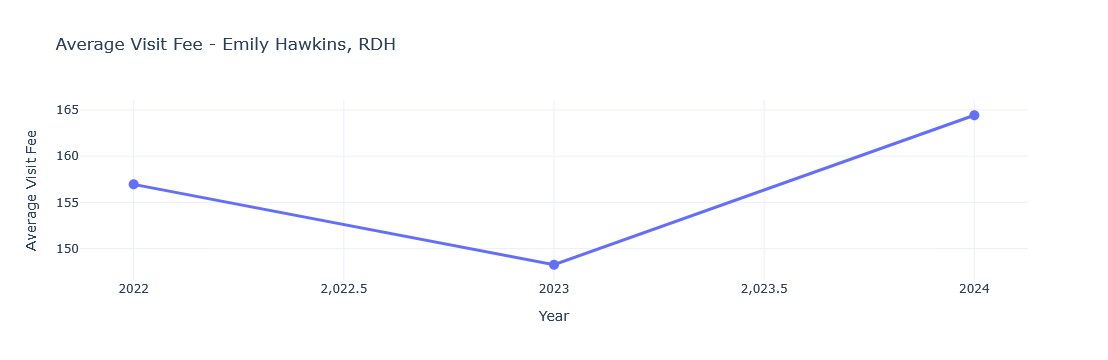


Answer: ### 1. **Direct Answer**:  
The average visit fee for Emily Hawkins, RDH:  
- **2022**: $156.95  
- **2023**: $148.26 (**-5.5%** decrease from 2022)  
- **2024**: $164.42 (**+10.9%** increase from 2023).  

### 2. **Comparative Context**:  
- **Vs. Other Hygienists**:  
  - Farah Rahman, RDH: $139–$160 (Emily’s fees are **higher** every year).  
  - "Hyg Hyg": $138–$167 (Emily’s 2024 fee is slightly below their peak).  
- **Vs. Practice Average**:  
  - Emily’s fees are **above the hygienist average** (typically $140–$160 range) but below specialty providers (e.g., DDS/DMI).  

### 3. **Key Insights**:  
- **Strengths**:  
  - 2024 fee increase suggests potential **higher-value services** or fee adjustments.  
- **Concerns**:  
  - **2023 dip** may reflect discounts, insurance changes, or less complex procedures.  
- **Implications**:  
  - Stable fees indicate **consistent patient value**, but monitor 2024’s higher fee sustainability (low patient volume that year).  

### 4. 

In [9]:
# Load data
practice_data = DentalPracticeData(
    json_file_path="demo_clinic.json",
    productivity_csv="CSVs/productivity_2022_2025_all.csv",
    procedures_csv="CSVs/procedures_2022_2025_all.csv"
)

# Test various questions - the LLM will handle them all
test_questions = [
    "What is the average visit fee for Emily Hawkins, RDH?"
]

#"What is the average visit fee for Emily Hawkins, RDH?",
#"Show me the productivity trend for Peter S. Chang, DDS",
#"What are the collection rates for Michele Chiafulio-Zasada, RDH?",
#"How many patients did Harvey Seybold, DDS see?",
#"What is the total production for Farah Rahman, RDH?"

for q in test_questions:
    print(f"\n{'='*60}")
    print(f"Question: {q}")
    result = process_question_with_visualizations(q, practice_data)
    print(f"\nAnswer: {result['answer'][:5000]}")